# FLO Unsupervised Learning Customer Segmentation

**İş Problemi**

Unsupervised Learning yöntemleriyle (Kmeans, Hierarchical Clustering ) müşteriler kümelere ayrılıp davranışları gözlemlenmek istenmektedir.

**Veri Seti Hikayesi**

Veri seti son alışverişlerini 2020 - 2021 yıllarında OmniChannel(hem online hem offline) olarak yapan müşterilerin geçmiş alışveriş davranışlarından elde edilen bilgilerden oluşmaktadır.

**Değişkenler**

master_id: Eşsiz müşteri numarası

order_channel : Alışveriş yapılan platforma ait hangi kanalın kullanıldığı (Android, ios, Desktop, Mobile, Offline)

last_order_channel : En son alışverişin yapıldığı kanal

first_order_date : Müşterinin yaptığı ilk alışveriş tarihi

last_order_date : Müşterinin yaptığı son alışveriş tarihi

last_order_date_online : Muşterinin online platformda yaptığı son alışveriş tarihi

last_order_date_offline : Muşterinin offline platformda yaptığı son alışveriş tarihi

order_num_total_ever_online : Müşterinin online platformda yaptığı toplam alışveriş sayısı

order_num_total_ever_offline : Müşterinin offline'da yaptığı toplam alışveriş sayısı

customer_value_total_ever_offline : Müşterinin offline alışverişlerinde ödediği toplam ücret

customer_value_total_ever_online : Müşterinin online alışverişlerinde ödediği toplam ücret

interested_in_categories_12 : Müşterinin son 12 ayda alışveriş yaptığı kategorilerin listesi

store_type : 3 farklı companyi ifade eder. A company'sinden alışveriş yapan kişi B'den de yaptı ise A,B şeklinde yazılmıştır.


# Veriyi Hazırlama

In [1]:
import pandas as pd
from scipy import stats
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler , StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage , fcluster
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.width',500)
pd.set_option('display.expand_frame_repr',False)
pd.set_option('display.float_format', lambda x:'%.5f' % x)

In [2]:
# flo_data_20K.csv verisini okutunuz.

df = pd.read_csv("/kaggle/input/flo-dataset/flo_data_20k.csv")
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.00000,1.00000,139.99000,799.38000,[KADIN]
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.00000,2.00000,159.97000,1853.58000,"[ERKEK, COCUK, KADIN, AKTIFSPOR]"
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.00000,2.00000,189.97000,395.35000,"[ERKEK, KADIN]"
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.00000,1.00000,39.99000,81.98000,"[AKTIFCOCUK, COCUK]"
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.00000,1.00000,49.99000,159.99000,[AKTIFSPOR]


In [3]:
# Müşterileri segmentlerken kullanacağınız değişkenleri seçiniz.
# Not: Tenure (Müşterinin yaşı), Recency (en son kaç gün önce alışveriş yaptığı) gibi yeni değişkenler oluşturabilirsiniz.
# Recency(yenilik) : müşterinin yenilik, yada bizden en son ne zaman alışveriş yaptığı durumunu ifade eder.
# Frequency(Sıklık) : müşterinin yaptığı alışveriş/işlem sayısı.
# Monetary(Parasal Değer):  Müşterilerin bize bıraktığı parasal değeri ifade eder

date_columns=df.columns[df.columns.str.contains("date")]
df[date_columns]=df[date_columns].apply(pd.to_datetime)
df.info()

analysis_date = df["last_order_date"].max() + pd.Timedelta(days = 2)

df["recency"] = (analysis_date - df["last_order_date"]).dt.days
df["tenure"] = (analysis_date - df["first_order_date"]).dt.days
df["frequency"] = df["order_num_total_ever_online"] + df["order_num_total_ever_offline"]
df["monetary"] = df["customer_value_total_ever_offline"] + df["customer_value_total_ever_online"]

# Modele girecek değişkenler ayrı bir dataframe'e aktarıldı
model_df = df[["frequency","monetary","recency","tenure"]]
model_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   master_id                          19945 non-null  object        
 1   order_channel                      19945 non-null  object        
 2   last_order_channel                 19945 non-null  object        
 3   first_order_date                   19945 non-null  datetime64[ns]
 4   last_order_date                    19945 non-null  datetime64[ns]
 5   last_order_date_online             19945 non-null  datetime64[ns]
 6   last_order_date_offline            19945 non-null  datetime64[ns]
 7   order_num_total_ever_online        19945 non-null  float64       
 8   order_num_total_ever_offline       19945 non-null  float64       
 9   customer_value_total_ever_offline  19945 non-null  float64       
 10  customer_value_total_ever_online  

,frequency,monetary,recency,tenure
0,5.00000,939.37000,95,214
1,21.00000,2013.55000,105,1574
2,5.00000,585.32000,186,552
3,2.00000,121.97000,135,146
4,2.00000,209.98000,86,668


frequency's: Skew: 9.142209056779548, : SkewtestResult(statistic=146.5525046688009, pvalue=0.0)
monetary's: Skew: 17.40528126665466, : SkewtestResult(statistic=176.82377384378034, pvalue=0.0)
recency's: Skew: 0.6172488156761073, : SkewtestResult(statistic=32.86977170491703, pvalue=5.944419293752164e-237)
tenure's: Skew: 1.7780382769412224, : SkewtestResult(statistic=71.61544418232309, pvalue=0.0)


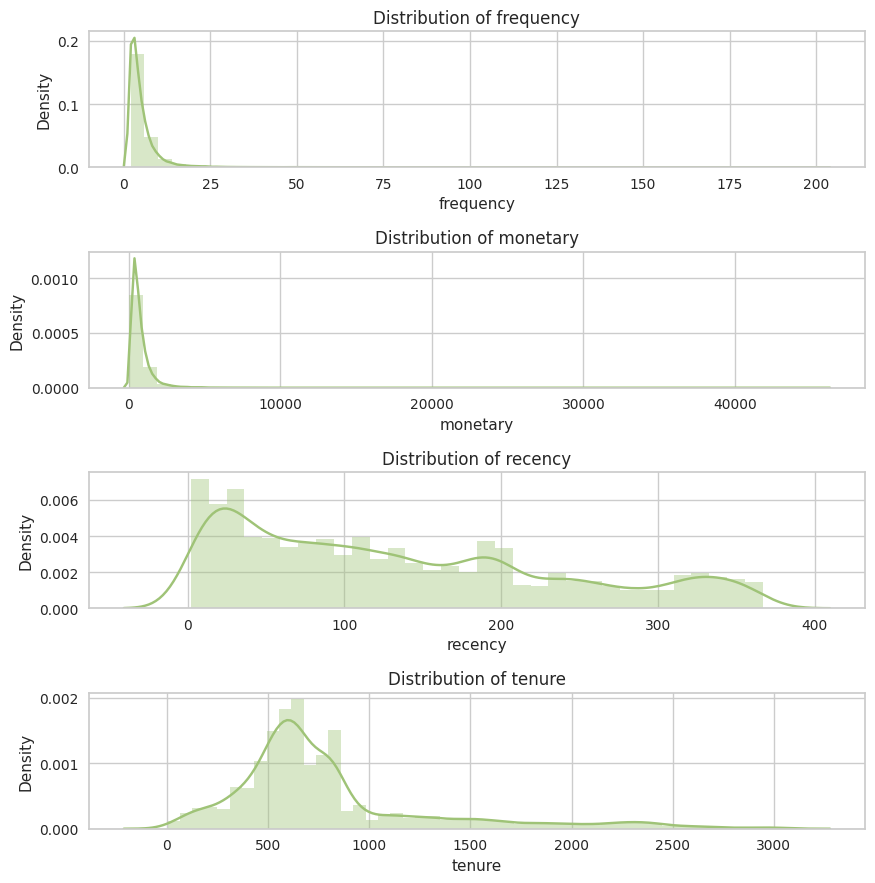

In [4]:
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column],color = "g")
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

plt.figure(figsize=(9, 9))
plt.subplot(4, 1, 1)
check_skew(model_df,'frequency')
plt.subplot(4, 1, 2)
check_skew(model_df,'monetary')
plt.subplot(4, 1, 3)
check_skew(model_df,'recency')
plt.subplot(4, 1, 4)
check_skew(model_df,'tenure')
plt.tight_layout()
plt.show(block=True)

# K-Means ile Müşteri Segmentasyonu

In [5]:
# Değişkenleri standartlaştırınız.

sc = StandardScaler()
model_scaling = sc.fit_transform(model_df)
model_df=pd.DataFrame(model_scaling,columns=model_df.columns)
model_df.head()

,frequency,monetary,recency,tenure
0,-0.00522,0.21011,-0.38206,-1.12213
1,3.36846,1.40980,-0.28523,1.47635
2,-0.00522,-0.18531,0.49905,-0.47633
3,-0.63779,-0.70280,0.00524,-1.25205
4,-0.63779,-0.60451,-0.46920,-0.25469


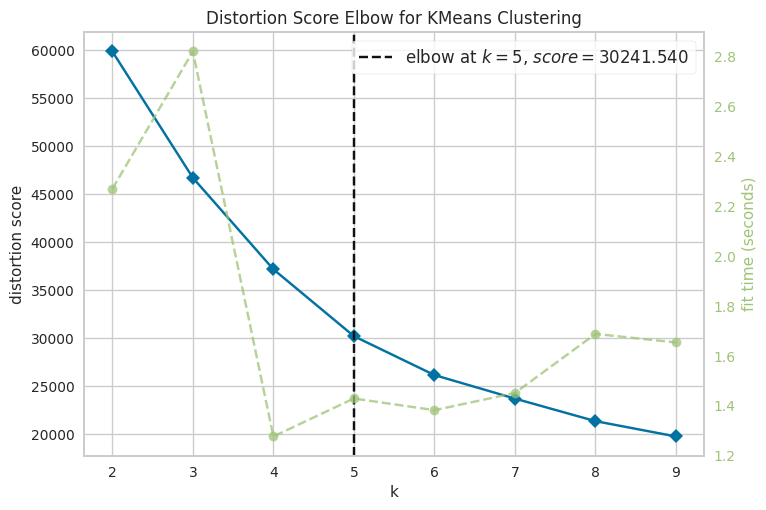

5

In [6]:
# Optimum küme sayısını belirleyiniz.

kmeans = KMeans(random_state=42)
elbow = KElbowVisualizer(kmeans, k=(2, 10))
elbow.fit(model_df)
elbow.show(block=True)

# Siyah çizgi çekilen kısım bize en optimum küme sayısını belli ediyor.Bu grafiğe göre 5 olmalı.
elbow.elbow_value_

In [7]:
#  Modelinizi oluşturunuz ve müşterilerinizi segmentleyiniz.
k_means = KMeans(n_clusters = 5, random_state= 42).fit(model_df)
segments=k_means.labels_
segments

array([0, 3, 1, ..., 0, 0, 1], dtype=int32)

In [8]:
final_df = df[["master_id","frequency","monetary","recency","tenure"]]
final_df["segment"] = segments + 1
final_df.head()

,master_id,frequency,monetary,recency,tenure,segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,5.00000,939.37000,95,214,1
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,21.00000,2013.55000,105,1574,4
2,69b69676-1a40-11ea-941b-000d3a38a36f,5.00000,585.32000,186,552,2
3,1854e56c-491f-11eb-806e-000d3a38a36f,2.00000,121.97000,135,146,1
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,2.00000,209.98000,86,668,1


In [9]:
# Herbir segmenti istatistiksel olarak inceleyeniz.

final_df.groupby("segment").agg({"frequency":["mean","min","max"],
                                 "monetary":["mean","min","max"],
                                 "recency":["mean","min","max"],
                                 "tenure":["mean","min","max","count"]})

frequency                      monetary                           recency               tenure                   
             mean     min       max        mean         min         max      mean  min  max       mean   min   max  count
segment                                                                                                                  
1         4.29069 2.00000  16.00000   655.53128    49.98000  2958.84000  65.92711    2  185  593.68259     5  1518  10592
2         3.67473 2.00000  14.00000   540.18542    44.98000  3615.67000 250.82511  146  367  679.63421   164  1704   6244
3         6.43670 2.00000  18.00000   818.99786    44.98000  3341.78000 152.85519    2  367 1940.54098  1078  3054   2196
4        18.74226 4.00000  88.00000  2922.72101   617.68000 12726.10000  89.72235    2  364 1301.25332    91  3060    904
5        83.22222 4.00000 202.00000 25178.11778 10383.44000 45905.10000  60.11111   14  209 1366.88889    55  3022      9

# Hierarchical Clustering ile Müşteri Segmentasyonu

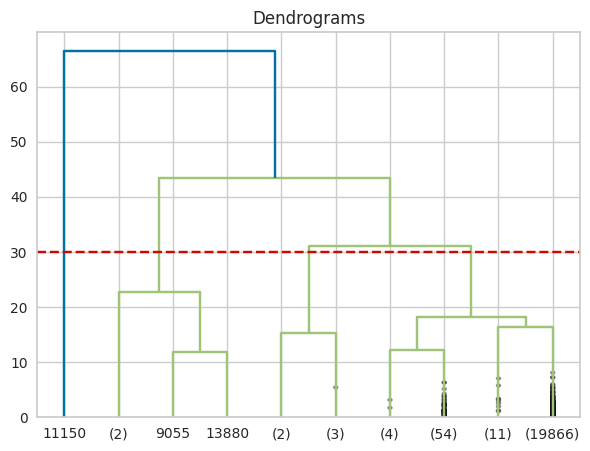

In [10]:
# Standırlaştırdığınız dataframe'i kullanarak optimum küme sayısını belirleyiniz.

hc_complete = linkage(model_df, 'complete')

plt.figure(figsize=(7, 5))
plt.title("Dendrograms")
dend = dendrogram(hc_complete,
           truncate_mode="lastp",
           p=10,
           show_contracted=True,
           leaf_font_size=10)
plt.axhline(y=30, color='r', linestyle='--')
plt.show(block=True)

Burada y değerini 30 seçtiğimiz için 30'dan çizgi çekti.

In [11]:
# Modelinizi oluşturunuz ve müşterileriniz segmentleyiniz.

hc = AgglomerativeClustering(n_clusters=4)
segments = hc.fit_predict(model_df)

final_df = df[["master_id","frequency","monetary","recency","tenure"]]
final_df["segment"] = segments +1
final_df.head()

,master_id,frequency,monetary,recency,tenure,segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,5.00000,939.37000,95,214,2
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,21.00000,2013.55000,105,1574,1
2,69b69676-1a40-11ea-941b-000d3a38a36f,5.00000,585.32000,186,552,3
3,1854e56c-491f-11eb-806e-000d3a38a36f,2.00000,121.97000,135,146,2
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,2.00000,209.98000,86,668,2


In [12]:
# Her bir segmenti istatistiksel olarak inceleyeniz.

final_df.groupby("segment").agg({"frequency":["mean","min","max"],
                                 "monetary":["mean","min","max"],
                                 "recency":["mean","min","max"],
                                 "tenure":["mean","min","max","count"]})

frequency                     monetary                         recency               tenure                  
             mean     min       max       mean       min         max      mean  min  max       mean  min   max  count
segment                                                                                                              
1        18.25690 4.00000 202.00000 2836.92615 351.88000 45905.10000  80.38630    2  364 1482.10942   55  3060   1051
2         4.55949 2.00000  18.00000  707.00483  49.98000  3615.67000  72.72614    2  364  595.51461    5  1775  10783
3         3.46596 2.00000  11.00000  496.29647  44.98000  2145.38000 250.53501  105  367  706.82746  136  2007   6213
4         5.44362 2.00000  19.00000  682.21016  44.98000  2432.52000 135.14542    2  367 1902.70548  928  3054   1898